# Packages & functions

TODO:
- Why buffer size = 1?

In [114]:
import os
import numpy as np
import cv2
import tensorflow as tf

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
from os.path import isdir

In [117]:
from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense

In [118]:
class DataProperties:
    data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/Data/'
    covid_path = data_path + 'covid/'
    pneumonia_path = data_path + 'pneumonia/'
    healthy_path = data_path + 'normal/'

    healthy_class = 0
    covid_class = 1
    pneumonia_class = 2

class TrainParameters:
    train_size = 0.8
    random_state = 123
    batch_size = 32

class PreprocParameters:
    resize_shape = (500, 500)

# Data download

## Paths download

In [119]:
import os
# Load filenames
def load_filenames(data_path, max_files = None):
    p = os.listdir(data_path)
    if max_files is not None:
        p = p[: min(max_files, len(p))]
    p = [data_path + file_path for file_path in p]
    return p

In [120]:
max_files = 100
covid_fnames = load_filenames(DataProperties.covid_path, max_files)
pn_fnames = load_filenames(DataProperties.pneumonia_path, max_files)
healthy_fnames = load_filenames(DataProperties.healthy_path, max_files)

In [121]:
import numpy as np

covid_labels = np.full(
    len(covid_fnames), fill_value = DataProperties.covid_class
)

pn_labels = np.full(
    len(pn_fnames), fill_value = DataProperties.pneumonia_class
)

healthy_labels = np.full(
    len(healthy_fnames), fill_value = DataProperties.healthy_class
)

In [122]:
X = [
     *covid_fnames, *pn_fnames, *healthy_fnames
]

Y = [
     *covid_labels, *pn_labels, *healthy_labels
]

## Split

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size = TrainParameters.train_size,
    random_state = TrainParameters.random_state,
    stratify = Y
)

# Data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


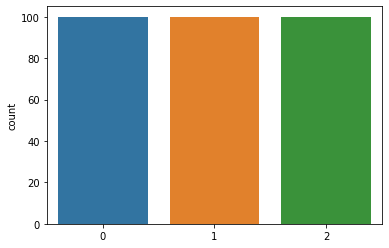

In [125]:
import seaborn as sns

_ = sns.countplot(Y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


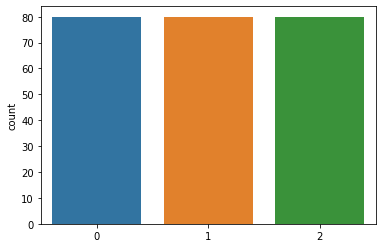

In [126]:
_ = sns.countplot(Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


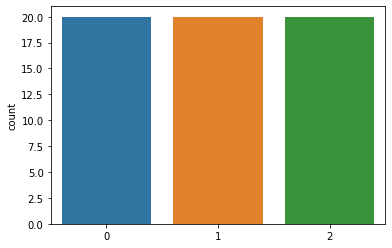

In [127]:
_ = sns.countplot(Y_test)

In [128]:
def load_image(full_path):
    print(f'Loading, {full_path}')
    img = cv2.imread(full_path, cv2.IMREAD_COLOR)
    return img

Loading, /content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (401).jpg


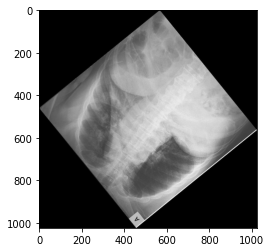

In [129]:
import matplotlib.pyplot as plt
im = load_image(X[0])
plt.imshow(im.astype('uint8'))

# Creating dataset

In [130]:
def resize_image(image, new_shape):
    n = cv2.resize(image, new_shape)
    return n

def normalize_image(image):
    return tf.cast(image, tf.float32) / 255.


def create_dataset(file_names, shuffle, cache_file):
    dataset = tf.data.Dataset.from_tensor_slices(
        file_names
    )

    # load image func
    load_im = lambda full_path: (
        tf.numpy_function(load_image, [full_path], tf.float32)
    )

    # # resize
    # resize_im = lambda image: (
    #     tf.numpy_function(
    #         resize_image, 
    #         [image, PreprocParameters.resize_shape], 
    #         tf.float32
    #     )
    # )

    # # normalize
    # normalize_im = lambda image: (
    #     tf.numpy_function(
    #         normalize_image,
    #         [image],
    #         tf.float32
    #     )
    # )

    dataset = dataset.map(load_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(resize_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(normalize_im, num_parallel_calls = os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(
        batch_size = TrainParameters.batch_size
    )

    # Prefetch
    dataset = dataset.prefetch(buffer_size = 1)

    return dataset

In [131]:
train_dataset = create_dataset(
    X_train,
    shuffle = True,
    cache_file = None # 'train_cache'
)

test_dataset = create_dataset(
    X_test,
    shuffle = True,
    cache_file = None # 'test_cache'
)

# CNN model

Loading, /content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000428_000.png


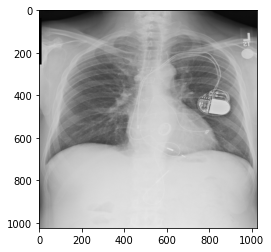

In [132]:
plt.imshow(load_image('/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000428_000.png'))

In [135]:
for i in train_dataset:
    pass

Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000417_004.png'Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000459_000.png'

Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/pneumonia/person1867_bacteria_4741.jpeg'Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/pneumonia/person1550_virus_2691.jpeg'



UnknownError: ignored